## Import libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from darts.datasets import TrafficDataset, AirPassengersDataset, AustralianTourismDataset
from ucimlrepo import fetch_ucirepo 

## Import Data
- We try multiple datasets to see which provides us with the best outcome

In [2]:
room_occupancy_estimation = fetch_ucirepo(id=864) 
room_df = room_occupancy_estimation['data']['features']
room_df = pd.concat([room_df, room_occupancy_estimation['data']['targets']], axis = 1)
room_df['Capacity %'] = room_df['Room_Occupancy_Count']/max(room_df['Room_Occupancy_Count'])

airpass_raw = AirPassengersDataset().load().pd_dataframe().reset_index()
airpass_raw.columns.name = None

airpass_raw

,Month,#Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


## Airpassenger Model

### Data preprocessing
- Scale the data
    - Make sure each data entry is $0\leq x\leq 1$

In [3]:
## Find local minimums and plot the month
airpass_data = airpass_raw.copy()
airpass_data['LMin'] = 0
airpass_data['LMax'] = 0
passengers = []

for row, index in airpass_data.iterrows():
    passengers.append(index['#Passengers'])
    
for i in range(len(passengers)):
    if i > 0 and i < len(passengers)-1:
        if passengers[i] < passengers[i-1] and passengers[i] < passengers[i+1]:
            airpass_data.loc[i, "LMin"] = 1
        if passengers[i] > passengers[i-1] and passengers[i] > passengers[i+1]:
            airpass_data.loc[i, "LMax"] = 1

## Keep out these values to prevent any errors
to_conc = airpass_data[['Month', "LMin", "LMax"]]

## Scale train and test
scaler = MaxAbsScaler()
airpass_scaled_data = pd.DataFrame(scaler.fit_transform(np.array(airpass_data.drop(columns = ['Month', "LMin", "LMax"])))).rename(columns = {0:"# Passengers"})

## Add month to both
airpass_scaled_data = pd.concat([to_conc, airpass_scaled_data], axis = 1)
airpass_scaled_data

,Month,LMin,LMax,# Passengers
0,1949-01-01,0,0,0.180064
1,1949-02-01,0,0,0.189711
2,1949-03-01,0,1,0.212219
3,1949-04-01,0,0,0.207395
4,1949-05-01,1,0,0.194534
...,...,...,...,...
139,1960-08-01,0,0,0.974277
140,1960-09-01,0,0,0.816720
141,1960-10-01,0,0,0.741158
142,1960-11-01,1,0,0.627010


### Plot scaled data
- Looking at the data we see some trends
    - Cyclical in nature
    - Upward trend from 1950 onwards

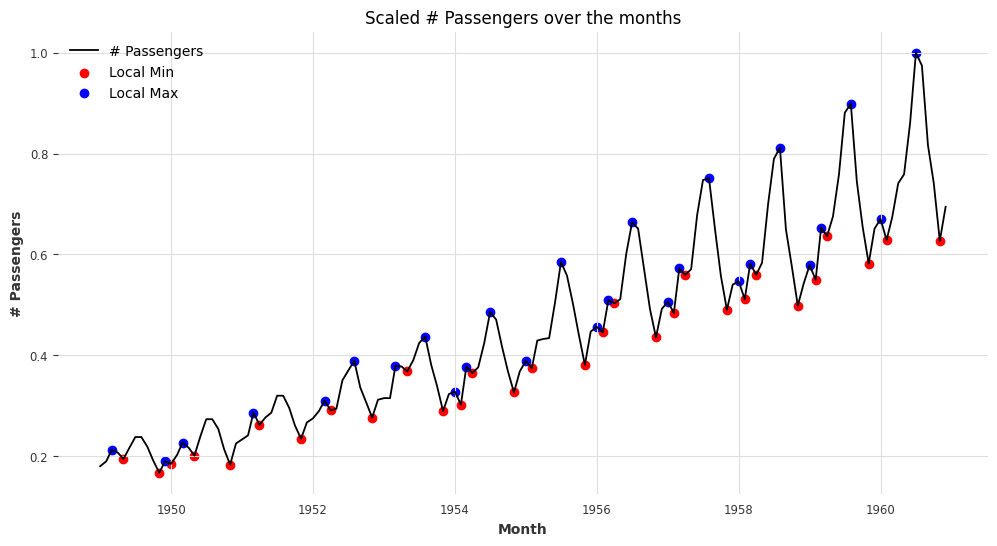

In [4]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))
lmins = airpass_scaled_data[airpass_scaled_data['LMin'] == 1]
lmaxs = airpass_scaled_data[airpass_scaled_data['LMax'] == 1]

axes.plot(airpass_scaled_data['Month'], airpass_scaled_data['# Passengers'], label = '# Passengers')
axes.set_xlabel("Month")
axes.set_ylabel("# Passengers")
axes.set_title("Scaled # Passengers over the months")
axes.scatter(lmins['Month'], lmins['# Passengers'], color='red', label = 'Local Min')
axes.scatter(lmaxs['Month'], lmaxs['# Passengers'], color='blue', label = 'Local Max')
axes.legend()

plt.show()

### Fit a model on the data
- Invert the data

In [5]:
# ## Format to TimeSeries
# past = 24
# future = 24
# airpass_ts = TimeSeries.from_dataframe(airpass_scaled_data, "Month", "# Passengers")
# airpass_ts = airpass_ts.astype('float32')

# model = NHiTSModel(input_chunk_length = past, output_chunk_length = future)
# model.fit(airpass_ts, verbose = 0)

# ## Predict on self
# pred = model.predict(n = len(airpass_scaled_data['Month']), verbose = 0)

# ## Plot predict v train
# results_df = pd.DataFrame(scaler.inverse_transform(pred.values())).rename(columns = {0:"Predicted"})
# results_df = pd.concat([airpass_scaled_data['Month'], results_df, \
#                         pd.DataFrame(scaler.inverse_transform(airpass_ts.values()))], axis = 1)\
#                         .rename(columns = {0:"Actual"})

# plt.plot(results_df['Month'], results_df['Predicted'], label = 'Predicted')
# plt.plot(results_df['Month'], results_df['Actual'], label = 'Actual')
# plt.legend()
# plt.show()

# mse = round(sum((results_df['Predicted'] - results_df['Actual'])**2)/len(results_df['Predicted']), 3)
# mape = round(sum(abs((results_df['Predicted'] - results_df['Actual'])))/len(results_df['Predicted']), 3)

# print("MSE =", mse, "\nMAPE =", mape)

## Air dataset
- https://www.opendatanetwork.com/dataset/datahub.transportation.gov/xgub-n9bw

In [6]:
carrier_raw = pd.read_csv("carrier_passengers.csv")
carrier_df = carrier_raw[carrier_raw['Year'] == 2023].sort_values(by = 'data_dte').reset_index(drop = True)
carrier_df = carrier_df.drop(columns=["data_dte", "usg_apt_id", "usg_wac", "fg_apt_id", "fg_wac", "airlineid", "type", "Scheduled", "Charter"])

carrier_df

,Year,Month,usg_apt,fg_apt,carrier,carriergroup,Total
0,2023,1,MIA,CLO,AA,1,18315
1,2023,1,IAD,DND,AOQ,0,3
2,2023,1,IAD,DEL,AI,0,5385
3,2023,1,IAD,CPT,UA,1,5662
4,2023,1,IAD,CPH,SK,0,5190
...,...,...,...,...,...,...,...
32448,2023,12,TEB,LBG,VJT,0,7
32449,2023,12,TEB,LBG,1HQ,0,7
32450,2023,12,TEB,KEF,AOQ,0,7
32451,2023,12,TEB,LTN,HUQ,0,2


### Numeric encoding
- Tried one-hot and PCA, didn't work well
    - Create the encoding for the flight and carrier, and use pca to determine which columns are most useful in determining the total
- Scale the data

In [7]:
columns_to_encode = ['usg_apt', 'fg_apt', 'carrier']
temp_df = carrier_df.copy()
temp_df = temp_df[columns_to_encode]

model_df = carrier_df.copy()

## Construct encoders
le_usg_apt = LabelEncoder()
le_fg_apt = LabelEncoder()
le_carrier = LabelEncoder()

## Encode the data
model_df['usg_apt_encoded'] = le_usg_apt.fit_transform(model_df['usg_apt'])
model_df['fg_apt_encoded'] = le_fg_apt.fit_transform(model_df['fg_apt'])
model_df['carrier_encoded'] = le_carrier.fit_transform(model_df['carrier'])
model_df = model_df.drop(columns=['usg_apt', 'fg_apt', 'carrier']).rename(columns = {0:"Month", 1:"carriergroup", 2:"Total"})

model_df.head()

,Year,Month,carriergroup,Total,usg_apt_encoded,fg_apt_encoded,carrier_encoded
0,2023,1,1,18315,214,127,48
1,2023,1,0,3,157,164,56
2,2023,1,0,5385,157,160,52
3,2023,1,1,5662,157,140,184
4,2023,1,0,5190,157,139,170


### Fit the model on average passenger per month

In [8]:
## , 'carriergroup', 'usg_apt_encoded', 'fg_apt_encoded', 'carrier_encoded'
scaler = StandardScaler()
X = model_df[['Month']].drop_duplicates().reset_index(drop = True)
X['Year'] = 2023
model_df['Avg'] = model_df.groupby(by = 'Month')['Total'].transform("mean")
y = model_df[['Avg']].drop_duplicates().reset_index(drop = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = pd.DataFrame(scaler.fit_transform(y_test))

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test).flatten()
results_df = pd.DataFrame(y_pred).reset_index(drop = True)
results_df = pd.concat([y_test, results_df], axis = 1).rename(columns = {0:"Predicted", "Total": "Actual"})

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE = {rmse}", f"R^2 = {r2}", sep = '\n')
results_df

RMSE = 0.5287902181638201
R^2 = 0.7203809051742596


,Predicted,Predicted
0,0.133549,0.559985
1,1.152497,0.407262
2,-1.286046,-0.967246


### Forecast future data

In [9]:
future_data = X.copy()
future_data['Year'] = 2024

forecast_x = pd.DataFrame(model.predict(future_data).flatten()).rename(columns = {0:"Predicted"})
forecast_x = pd.concat([future_data, forecast_x], axis = 1)
forecast_x

,Month,Year,Predicted
0,1,2024,0.686782
1,2,2024,1.373565
2,3,2024,2.060347
3,4,2024,2.747130
4,5,2024,3.433912
5,6,2024,4.120695
6,7,2024,4.807477
7,8,2024,5.494260
8,9,2024,6.181042
9,10,2024,6.867825


## Use the API for modelling

In [10]:
from datetime import datetime, timedelta
from darts import TimeSeries
from src.forecasting_engine import get_data, write_forecast
import pandas as pd

## Timestamp ('%Y-%m-%dT%H:%M:%S'), node_id, noise (binary = loud or not), count
## Data to be collected every 15 mins
## Want to forecast for 6 hours = 24 future steps

end = datetime.now()
start = (end - timedelta(hours=24)).strftime('%Y-%m-%dT%H:%M:%S')
end = end.strftime('%Y-%m-%dT%H:%M:%S')

data_raw = get_data(start = start, end = end) ## only use the last 24 hours as input
n_future = 24

## Get forecast dates and times
end_time = datetime.now() + timedelta(hours = int(n_future/4))
future_times = []
current_time = datetime.now()
while current_time <= end_time:
    future_times.append(current_time.strftime('%Y-%m-%dT%H:%M:%S'))
    current_time += timedelta(minutes=15)
data_raw

,count,node_id,noise,timestamp
0,1,1,False,"Wed, 26 Jun 2024 17:57:14 GMT"
1,2,1,False,"Wed, 26 Jun 2024 17:57:58 GMT"
2,0,1,False,"Wed, 26 Jun 2024 17:58:41 GMT"
3,0,1,False,"Wed, 26 Jun 2024 17:59:25 GMT"
4,1,1,False,"Wed, 26 Jun 2024 18:00:09 GMT"
...,...,...,...,...
164,0,1,False,"Wed, 26 Jun 2024 22:29:56 GMT"
165,1,1,False,"Wed, 26 Jun 2024 22:30:20 GMT"
166,3,1,False,"Wed, 26 Jun 2024 22:36:27 GMT"
167,6,1,False,"Wed, 26 Jun 2024 22:42:25 GMT"


### Preprocess data and run model on new data
- We want to remove the node_id and, convert to timeseries
- Train the model on the new data
- Forecast future data

In [11]:
## Remove node_id
processed_data = data_raw.copy()
processed_data['Month'] = pd.to_datetime(processed_data['timestamp']).dt.month
processed_data['Year'] = pd.to_datetime(processed_data['timestamp']).dt.year
processed_data = processed_data[['Month', 'Year']].drop_duplicates()
new_data = pd.DataFrame({'Month': [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5], 'Year': [2024, 2024, 2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025, 2025, ]})

processed_data = pd.concat([processed_data, new_data], axis = 0).reset_index(drop = True)

## Predict model to our data
preds = list(model.predict(processed_data).flatten())
forecast_df = pd.DataFrame(preds).rename(columns = {0:"Forecast"})
start_time = datetime(2024, 6, 26, 20, 0, 0) 
end_time = datetime(2024, 6, 26, 23, 0, 0)  

# Generate timestamps in 15-minute intervals
timestamps = []
current_time = start_time
while current_time < end_time:
    timestamps.append(current_time)
    current_time += timedelta(minutes=15)

forecast_df['node_id'] = 1
forecast_df['Timestamp'] = timestamps

write_forecast(forecast_df, node_id = 1)
forecast_df

https://occupi-rp-hack-24.uc.r.appspot.com
[{"Forecast":4.1206949265,"node_id":1,"Timestamp":1719432000000},{"Forecast":4.8074774143,"node_id":1,"Timestamp":1719432900000},{"Forecast":5.494259902,"node_id":1,"Timestamp":1719433800000},{"Forecast":6.1810423898,"node_id":1,"Timestamp":1719434700000},{"Forecast":6.8678248775,"node_id":1,"Timestamp":1719435600000},{"Forecast":7.5546073653,"node_id":1,"Timestamp":1719436500000},{"Forecast":8.241389853,"node_id":1,"Timestamp":1719437400000},{"Forecast":0.6867824878,"node_id":1,"Timestamp":1719438300000},{"Forecast":1.3735649755,"node_id":1,"Timestamp":1719439200000},{"Forecast":2.0603474633,"node_id":1,"Timestamp":1719440100000},{"Forecast":2.747129951,"node_id":1,"Timestamp":1719441000000},{"Forecast":3.4339124388,"node_id":1,"Timestamp":1719441900000}]


,Forecast,node_id,Timestamp
0,4.120695,1,2024-06-26 20:00:00
1,4.807477,1,2024-06-26 20:15:00
2,5.494260,1,2024-06-26 20:30:00
3,6.181042,1,2024-06-26 20:45:00
4,6.867825,1,2024-06-26 21:00:00
5,7.554607,1,2024-06-26 21:15:00
6,8.241390,1,2024-06-26 21:30:00
7,0.686782,1,2024-06-26 21:45:00
8,1.373565,1,2024-06-26 22:00:00
9,2.060347,1,2024-06-26 22:15:00
